In [2]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import scipy

mass_raw_data = pd.read_excel("rawdata_masslost.xls",
                              header=0,skiprows=[1],keep_default_na=False).drop(axis=1,index=[360,361])

hrr_report = {"Time": [0,5,10,15,20,25,30], "HRR": [0,45,2500,21800,19300,11300,2300]}

materials = pd.read_excel('rawdata_fireload.xlsx',0)

In [3]:
materials

,Brandstoff im Fahrzeug,m [kg],hu [kJ/kg],Q [MJ]
0,Innenverkleidung,391,18823,7360
1,Fußboden (Sperrholz),193,17235,3326
2,Fußboden (PVC-Belag),136,17898,2434
3,Sitze (Schaumstoff),157,22051,3462
4,Sitze (Kunstleder),32,19011,608
5,Holz,214,17280,3698
6,Gummiprofile,178,31025,5523
7,Kabelisolation,400,18000,7200
8,Spritzkork,82,23467,1924
9,Farbe,200,24570,4914


In [4]:
hoc_mean = materials[0:5]["Q [MJ]"].sum()/materials[0:5]["m [kg]"].sum()*1000
hoc_std = materials.loc[0:5, "hu [kJ/kg]"].std()

In [5]:
mass = mass_raw_data

mass["Time"] = np.arange(10,3601,10)
mass.loc[-1,"Time"] = [0]
mass.index = mass.index + 1
mass = mass.sort_index()

mass["Mass"] = mass["ges. Kraft.1"]
mass.loc[0,"Mass"] = mass.loc[2,"Mass"]
mass.loc[1,"Mass"] = mass.loc[2,"Mass"]

index_max = mass["Mass"].where(mass["Mass"] == mass["Mass"].max()).dropna().index

mass.loc[0:21, "Mass"] = mass.loc[21, "Mass"]

In [6]:
mass.head()

,2004-11-25 13:14:58,KMD 1,KMD 2,KMD 3,KMD 4,Kraft 1,Kraft 2,Kraft 3,Kraft 4,ges. Kraft,ges. Kraft.1,Sek. ab Start,max. Kraft 1,max. Kraft 2,max. Kraft 3,max. Kraft 4,Time,Mass
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,8324.585868
1,2004-11-25 13:14:58,-231.0363,-615.1675,-626.0588,-271.7337,10.8227,29.0931,29.749,12.7891,82.4539,8407.957865,10,11.3762,29.5638,29.864,12.8779,10.0,8324.585868
2,2004-11-25 13:15:08,-227.115,-601.0675,-626.5988,-271.225,10.6385,28.4216,29.7748,12.765,81.5999,8320.874101,20,11.3762,29.5638,29.864,12.8779,20.0,8324.585868
3,2004-11-25 13:15:18,-227.0975,-600.965,-626.7,-271.335,10.6377,28.4167,29.7797,12.7702,81.6043,8321.322776,30,11.3762,29.5638,29.864,12.8779,30.0,8324.585868
4,2004-11-25 13:15:28,-227.26,-600.9825,-626.6963,-271.3313,10.6453,28.4176,29.7795,12.7701,81.6125,8322.158943,39.8,11.3762,29.5638,29.864,12.8779,40.0,8324.585868


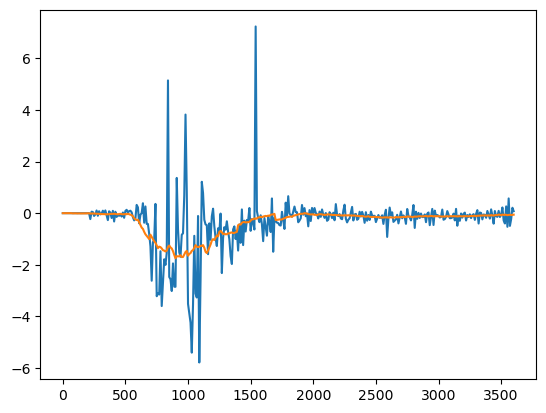

In [7]:
mass["MLR"] = np.diff(mass["Mass"],prepend=mass.loc[0,"Mass"])/10
mass["MLR"] = mass["MLR"].astype('float64')

mass["MLR_filter"] = scipy.ndimage.uniform_filter1d(mass["MLR"], size=30)

plt.plot(mass["Time"],mass["MLR"])
plt.plot(mass["Time"],mass["MLR_filter"])

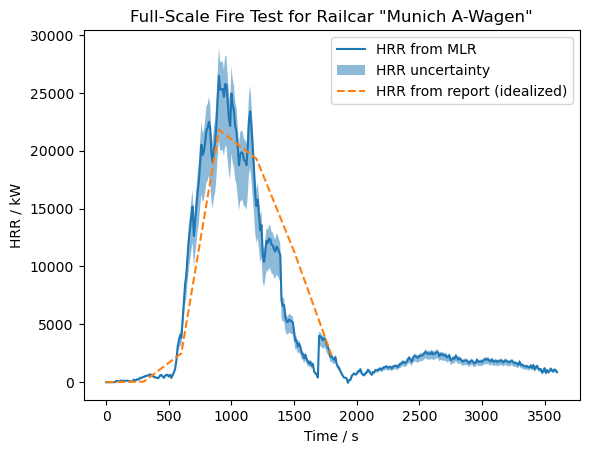

In [8]:
mass["HRR"] = -1 * mass["MLR_filter"] * 0.8 * hoc_mean
mass["HRR_min"] = -1 * mass["MLR_filter"] * 0.7 * (hoc_mean - hoc_std)
mass["HRR_max"] = -1 * mass["MLR_filter"] * 0.8 * (hoc_mean + hoc_std)

plt.plot(mass["Time"],mass["HRR"],label="HRR from MLR")
plt.fill_between(mass["Time"], mass["HRR_min"], mass["HRR_max"], alpha=0.5, label="HRR uncertainty")
plt.plot(np.array(hrr_report["Time"])*60,hrr_report["HRR"],linestyle="--",label="HRR from report (idealized)")
plt.title('Full-Scale Fire Test for Railcar "Munich A-Wagen"')
plt.xlabel("Time / s")
plt.ylabel("HRR / kW")
plt.legend()
plt.savefig("full-scale fire test.png",dpi=300)

In [9]:
mass.head()

,2004-11-25 13:14:58,KMD 1,KMD 2,KMD 3,KMD 4,Kraft 1,Kraft 2,Kraft 3,Kraft 4,ges. Kraft,...,max. Kraft 2,max. Kraft 3,max. Kraft 4,Time,Mass,MLR,MLR_filter,HRR,HRR_min,HRR_max
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,8324.585868,0.0,0.0,-0.0,-0.0,-0.0
1,2004-11-25 13:14:58,-231.0363,-615.1675,-626.0588,-271.7337,10.8227,29.0931,29.749,12.7891,82.4539,...,29.5638,29.864,12.8779,10.0,8324.585868,0.0,0.0,-0.0,-0.0,-0.0
2,2004-11-25 13:15:08,-227.115,-601.0675,-626.5988,-271.225,10.6385,28.4216,29.7748,12.765,81.5999,...,29.5638,29.864,12.8779,20.0,8324.585868,0.0,0.0,-0.0,-0.0,-0.0
3,2004-11-25 13:15:18,-227.0975,-600.965,-626.7,-271.335,10.6377,28.4167,29.7797,12.7702,81.6043,...,29.5638,29.864,12.8779,30.0,8324.585868,0.0,0.0,-0.0,-0.0,-0.0
4,2004-11-25 13:15:28,-227.26,-600.9825,-626.6963,-271.3313,10.6453,28.4176,29.7795,12.7701,81.6125,...,29.5638,29.864,12.8779,40.0,8324.585868,0.0,0.0,-0.0,-0.0,-0.0


In [10]:
export = mass[["Time","HRR"]]
export.to_csv("full-scale fire test.csv")